In [3]:
from tqdm import tqdm
import json

VQA_MODEL_TO_DISPLAYNAME = {
    'instructblipflant5xl': 'InstructBLIP',
    'blip2flant5xl': 'BLIP2',
    'llavaplus7b': 'LLaVA-1.5-7B'
}

DATASET_TO_DISPLAYNAME = {
    'okvqa': 'OK-VQA',
    'aokvqa': 'A-OKVQA'
}

DATASET_TO_TRAINSIZE = {
    'okvqa': 9009,
    'aokvqa': 17056
}
DATASET_TO_VALSIZE = {
    'okvqa': 5046,
    'aokvqa': 1075
}

from data.aokvqa import AOKVQADataset
d = AOKVQADataset('val')

vqa_model = 'llavaplus7b'
dataset = 'aokvqa'
mode = 'direct_answer'

vqa_model_displayname =  VQA_MODEL_TO_DISPLAYNAME[vqa_model]
dataset_displayname = DATASET_TO_DISPLAYNAME[dataset]
dataset_trainsize = DATASET_TO_TRAINSIZE[dataset]
dataset_valsize = DATASET_TO_VALSIZE[dataset]

qid2trainrollouts = json.load(open(f'/home/tejas/experiments/recoverr/directvqa/{dataset}_{mode}/train_outputs/{vqa_model}_direct_vqa-1rollouts-{dataset_trainsize}examples.json'))
qid2valrollouts = json.load(open(f'/home/tejas/experiments/recoverr/directvqa/{dataset}_{mode}/val_outputs/{vqa_model}_direct_vqa-1rollouts-{dataset_valsize}examples.json'))
train_qids = list(qid2trainrollouts.keys())
train_qids = train_qids[:5000]
qid2trainrollouts = {k: qid2trainrollouts[k] for k in train_qids}

#qid2valrollouts = {k: qid2valrollouts[k] for k in qid2valrollouts if d.data[int(k)]['difficult_direct_answer'] == False}

print(f"Loaded {len(qid2trainrollouts)} qids from {vqa_model_displayname} {dataset} train rollouts")
print(f"Loaded {len(qid2valrollouts)} qids from {vqa_model_displayname} {dataset} val rollouts")


05/01/2024 09:21:50 - INFO - data.aokvqa - Loaded A-OKVQA val dataset with 1075 examples!
05/01/2024 09:21:50 - WARNING - data.aokvqa - Vision/text processors not set!


Loaded 5000 qids from LLaVA-1.5-7B aokvqa train rollouts
Loaded 1075 qids from LLaVA-1.5-7B aokvqa val rollouts


In [4]:
def calculate_abstention_metrics(qid2rollouts, threshold, error_cost=1):
    num_covered, total_risk, effective_reliability = 0, 0, 0
    qids = list(qid2rollouts.keys())
    abstained_qids = []
    for qid in qids:
        rollout = qid2rollouts[qid][0]
        acc = rollout['lave_score']
        conf = rollout['answer_logprobs_dict']['yn_prob']
        selected = True if conf >= threshold else False
        if selected:
            num_covered += 1
            total_risk += 1 - acc #if acc != 1 else 0
            effective_reliability += acc if acc > 0 else -error_cost
        else:
            abstained_qids.append(qid)
    coverage = num_covered/len(qids)
    risk = total_risk/num_covered if num_covered > 0 else 0
    effective_reliability = effective_reliability/len(qids)
    return coverage, risk, effective_reliability, abstained_qids

num_thresholds = 100
penalty = 1
thresholds = [i/num_thresholds for i in range(1, num_thresholds)]
coverages, risks, eff_reliabilities = [], [], []
for t in tqdm(thresholds):
    c, r, e, _ = calculate_abstention_metrics(qid2trainrollouts, t, penalty)
    coverages.append(c)
    risks.append(r)
    eff_reliabilities.append(e)
#for t, c, r in zip(thresholds, coverages, risks):
#    print(f"At confidence threshold {t}, coverage={c:.2%}, risk={r:.2%}")

100%|██████████| 99/99 [00:00<00:00, 456.41it/s]


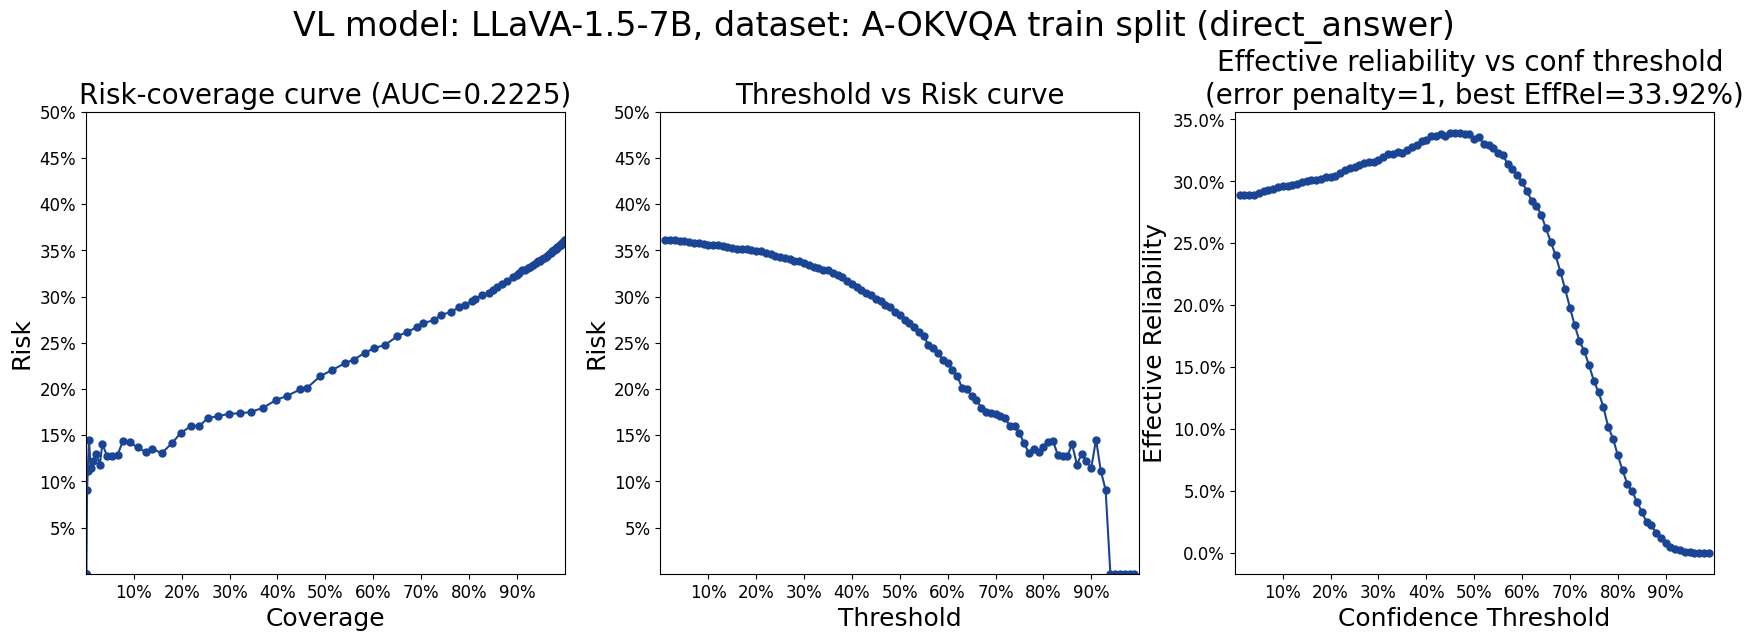

In [5]:
from sklearn import metrics
auc = metrics.auc(coverages, risks)

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

plt.size = (50, 25)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'VL model: {vqa_model_displayname}, dataset: {dataset_displayname} train split ({mode})\n\n\n\n', fontsize=24, y=1.05)
fig.set_size_inches(21, 6)
ax1.plot(coverages, risks, marker='.', markersize=10, color='#1a4595')
#ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Risk-coverage curve (AUC={auc:.4f})', fontsize=20)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 0.5)
ax1.set_xlabel('Coverage', fontsize=18)
ax1.set_ylabel('Risk', fontsize=18)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax2.plot(thresholds, risks, marker='.', markersize=10, color='#1a4595')
#ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax2.set_title(f'Threshold vs Risk curve', fontsize=20)
ax2.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax2.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 0.5)
ax2.set_xlabel('Threshold', fontsize=18)
ax2.set_ylabel('Risk', fontsize=18)
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax3.plot(thresholds, eff_reliabilities, marker='.', markersize=10, color='#1a4595')
#ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax3.set_title(f'Effective reliability vs conf threshold \n(error penalty={penalty}, best EffRel={max(eff_reliabilities):.2%})', fontsize=20)
ax3.set_xticks(ticks=[i/10 for i in range(1, 10)])
#ax.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.set_xlim(0, 1)
#ax.set_ylim(0, 0.5)
ax3.set_xlabel('Confidence Threshold', fontsize=18)
ax3.set_ylabel('Effective Reliability', fontsize=18)
ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

In [6]:
import os
best_er = max(eff_reliabilities)
best_er_idx = eff_reliabilities.index(best_er)
best_threshold = thresholds[best_er_idx]
print(f"Best Effective Reliability on {dataset} train set={best_er:.2%}, at confidence threshold = {best_threshold}")
print(f"At threshold={best_threshold}, train set coverage={coverages[best_er_idx]:.2%}, risk={risks[best_er_idx]:.2%}")

#best_threshold = 0.67
c, r, e, abstained_qids = calculate_abstention_metrics(qid2valrollouts, best_threshold, penalty)
print(f"\nOn {dataset} val set for that threshold:")
print(f"Coverage={c:.2%}, risk={r:.2%}, effective reliability={e:.2%}")
selected_eval_score = sum(qid2valrollouts[qid][0]['score'] for qid in qid2valrollouts if qid not in abstained_qids)/(len(qid2valrollouts)-len(abstained_qids))
selected_lave_score = sum(qid2valrollouts[qid][0]['lave_score'] for qid in qid2valrollouts if qid not in abstained_qids)/(len(qid2valrollouts)-len(abstained_qids))
abstained_eval_score = sum(qid2valrollouts[qid][0]['score'] for qid in qid2valrollouts if qid in abstained_qids)/len(abstained_qids)
abstained_lave_score = sum(qid2valrollouts[qid][0]['lave_score'] for qid in qid2valrollouts if qid in abstained_qids)/len(abstained_qids)
print(f"Selected subset: count = {len(qid2valrollouts)-len(abstained_qids)}, eval score={selected_eval_score:.2%}, LAVE score={selected_lave_score:.2%}")
print(f"Abstained subset: count = {len(abstained_qids)}, eval score={abstained_eval_score:.2%}, LAVE score={abstained_lave_score:.2%}")
#out_file = os.path.join('/net/nfs.cirrascale/mosaic/tejass/data/directvqa_abstained_qids/', f"{vqa_model}-{dataset}_val_{mode}-threshold{best_threshold:.2f}.txt")
#f = open(out_file, 'w')
#f.write('\n'.join(abstained_qids))
#f.close()

c, r, e, _ = calculate_abstention_metrics(qid2valrollouts, 0, penalty)
eval_score, lave_score = 0, 0
for qid in qid2valrollouts:
    rollout = qid2valrollouts[qid][0]
    eval_score += rollout['score']
    lave_score += rollout['lave_score']
print(f"\nCONFIDENCE-BLIND BASELINE: \nExact match eval score = {eval_score/len(qid2valrollouts):.2%}")
print(f"LAVE eval score = {lave_score/len(qid2valrollouts):.2%}")
print(f"\nIf we did not consider confidence at all (i.e. confidence threshold=0.0):")
print(f"Coverage={c:.2%}, risk={r:.2%}, effective reliability={e:.2%}")

Best Effective Reliability on aokvqa train set=33.92%, at confidence threshold = 0.47
At threshold=0.47, train set coverage=79.18%, risk=29.10%

On aokvqa val set for that threshold:
Coverage=82.14%, risk=22.88%, effective reliability=45.30%
Selected subset: count = 883, eval score=66.44%, LAVE score=77.12%
Abstained subset: count = 192, eval score=36.81%, LAVE score=44.53%

CONFIDENCE-BLIND BASELINE: 
Exact match eval score = 61.15%
LAVE eval score = 71.30%

If we did not consider confidence at all (i.e. confidence threshold=0.0):
Coverage=100.00%, risk=28.70%, effective reliability=43.67%


In [15]:
def coverage_at_risk(desired_risk):
    gamma = min([thresholds[i] for i in range(num_thresholds-1) if risks[i] < desired_risk])
    c, r, e, abstained_qids = calculate_abstention_metrics(qid2valrollouts, gamma, penalty)
    return gamma, c, r

def risk_at_coverage(desired_coverage):
    gamma = max([thresholds[i] for i in range(num_thresholds-1) if coverages[i] >= desired_coverage])
    c, r, e, abstained_qids = calculate_abstention_metrics(qid2valrollouts, gamma, penalty)
    return gamma, c, r

desired_coverage = 0.6688
desired_risk = 0.2
new_coverage = coverage_at_risk(desired_risk)
new_risk = risk_at_coverage(desired_coverage)
print(f"For desired risk={desired_risk:.2%}, threshold (on calib set)={new_coverage[0]}")
print(f"\tOn A-OKVQA val set, corresponding coverage={new_coverage[1]:.2%}, risk={new_coverage[2]:.2%}")
print(f"For desired coverage={desired_coverage:.2%}, threshold (on calib set)={new_risk[0]}")
print(f"\tOn A-OKVQA val set, corresponding coverage={new_risk[1]:.2%}, risk={new_risk[2]:.2%}")

For desired risk=20.00%, threshold (on calib set)=0.64
	On A-OKVQA val set, corresponding coverage=47.91%, risk=14.47%
For desired coverage=66.88%, threshold (on calib set)=0.54
	On A-OKVQA val set, corresponding coverage=70.51%, risk=19.72%


In [14]:
print(f"Risk-coverage levels for different thresholds (on calib set):")
for i in range(len(thresholds)):
    print(f"At threshold {thresholds[i]}, coverage={coverages[i]:.4f}, risk={risks[i]:.4f}")

Risk-coverage levels for different thresholds (on calib set):
At threshold 0.01, coverage=1.0000, risk=0.3608
At threshold 0.02, coverage=1.0000, risk=0.3608
At threshold 0.03, coverage=0.9998, risk=0.3607
At threshold 0.04, coverage=0.9996, risk=0.3605
At threshold 0.05, coverage=0.9984, risk=0.3598
At threshold 0.06, coverage=0.9970, risk=0.3589
At threshold 0.07, coverage=0.9958, risk=0.3581
At threshold 0.08, coverage=0.9944, risk=0.3574
At threshold 0.09, coverage=0.9930, risk=0.3565
At threshold 0.1, coverage=0.9920, risk=0.3558
At threshold 0.11, coverage=0.9912, risk=0.3557
At threshold 0.12, coverage=0.9896, risk=0.3553
At threshold 0.13, coverage=0.9878, risk=0.3547
At threshold 0.14, coverage=0.9846, risk=0.3532
At threshold 0.15, coverage=0.9832, risk=0.3525
At threshold 0.16, coverage=0.9822, risk=0.3520
At threshold 0.17, coverage=0.9816, risk=0.3518
At threshold 0.18, coverage=0.9802, risk=0.3515
At threshold 0.19, coverage=0.9776, risk=0.3501
At threshold 0.2, coverage=

In [13]:
print(f"Risk-coverage levels for different thresholds (on val set):")
for t in thresholds:
    c, r, e, abstained_qids = calculate_abstention_metrics(qid2valrollouts, t, penalty)
    print(f"At threshold {t}, coverage={c:.4f}, risk={r:.4f}")

Risk-coverage levels for different thresholds (on val set):
At threshold 0.01, coverage=1.0000, risk=0.2870
At threshold 0.02, coverage=1.0000, risk=0.2870
At threshold 0.03, coverage=0.9991, risk=0.2872
At threshold 0.04, coverage=0.9991, risk=0.2872
At threshold 0.05, coverage=0.9991, risk=0.2872
At threshold 0.06, coverage=0.9991, risk=0.2872
At threshold 0.07, coverage=0.9981, risk=0.2875
At threshold 0.08, coverage=0.9963, risk=0.2862
At threshold 0.09, coverage=0.9963, risk=0.2862
At threshold 0.1, coverage=0.9963, risk=0.2862
At threshold 0.11, coverage=0.9944, risk=0.2848
At threshold 0.12, coverage=0.9944, risk=0.2848
At threshold 0.13, coverage=0.9935, risk=0.2842
At threshold 0.14, coverage=0.9926, risk=0.2835
At threshold 0.15, coverage=0.9888, risk=0.2827
At threshold 0.16, coverage=0.9888, risk=0.2827
At threshold 0.17, coverage=0.9851, risk=0.2819
At threshold 0.18, coverage=0.9851, risk=0.2819
At threshold 0.19, coverage=0.9833, risk=0.2805
At threshold 0.2, coverage=0.